<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/gp_aprendizaje/modeloGausianoLineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias importadas y constantes usadas

In [104]:
# Modulos y constantes

import numpy as np
import random
import scipy
import scipy.linalg
from matplotlib import pyplot as plt

pi = np.pi

# Los siguientes parametros son cuadrados de las desviaciones estandar
sigma_signal_sq = 1.5 # desviación estándar del ruido usado para enmascarar la señal de entrenamiento
sigma_b_sq = 70.5 # En distribucion gaussiana a priori de modelo de regresióón linear, desviación estándar de la ordenada
sigma_m_sq = 10.0 # En distribucion gaussiana a priori de modelo de regresióón linear, desviación estándar de la pendiente

ordenada_real = 10.
pendiente_real = 5.

Informacion sobre la particion del sistema y las realizaciones a realizar

In [102]:
n_r = 4 # numero de realizaciones del proceso gaussiano

n_tp = 500 # puntos para muestrear el fondo continuo para la desviacion estándar

x_bot_b = -2.5
x_top_b = 14.

x = np.linspace(x_bot_b,x_top_b,n_tp)

n_test = 12 # puntos para realizar inferencia

x_train = np.linspace(x_bot_b,x_top_b,n_test)
y_train = np.fromiter([ordenada_real+pendiente_real*x+sigma_signal_sq*random.random() for x in x_train],float)


La siguiente celda contiene informacion sobre el conjunto de puntos - objetivos sobre el que entrenar el proceso gausiano, así como una especificación a priori de la matriz de covarianzas

[[1.5 0.  0.  ... 0.  0.  0. ]
 [0.  1.5 0.  ... 0.  0.  0. ]
 [0.  0.  1.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.5 0.  0. ]
 [0.  0.  0.  ... 0.  1.5 0. ]
 [0.  0.  0.  ... 0.  0.  1.5]]
-0.0 1.9822160120838973e+97
(500, 500) (500, 500)
(500, 12) (12, 12) (12,)


AttributeError: ignored

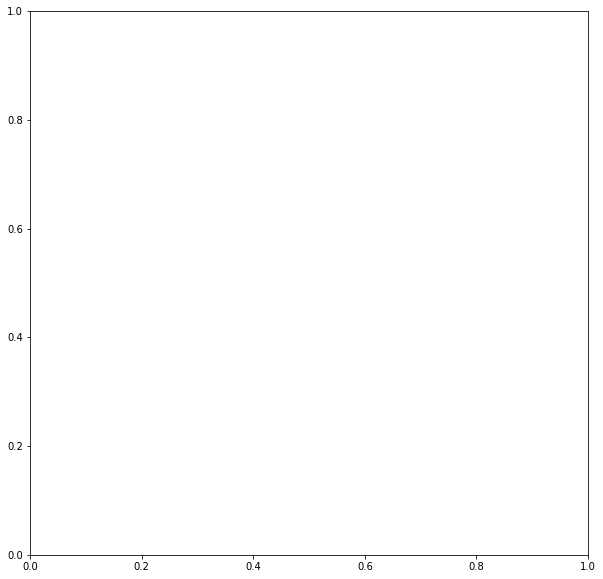

In [118]:

# Hacemos la proyeccion sobre el espacio propio del modelo de regresion linear y derivamos la matriz de dispersion de los parámetros
proyeccionlinear = espacioPropio()
mCov_x,phi_x,mean = proyeccionlinear.linear(x,sigma_b_sq,sigma_m_sq)
mCov_train,phi_train,mean_train = proyeccionlinear.linear(x_train,sigma_b_sq,sigma_m_sq)

# Generamos un proceso gausiano para generar la distribucion de funciones con probabilidades a priori (las que nos ofrece las incertidumbres en los parametros)
gp_cov_diag = gaussProcess(mCov_x,np.zeros(n_tp),phi_x)
gp_cov_diag.sigmaCalc(phi_x)
sigmaVal = gp_cov_diag.sigma

# Entrenamos con los datos proyectados sobre el espacio propio de esta regresion
gp_cov_diag.entrenarGP(phi_train,y_train,sigma_signal_sq)



visualizacion = datosVisualizacion()

visualizacion.add_sigma(x,sigmaVal)
visualizacion.add_mean(x,np.zeros(n_tp))
visualizacion.add_train_data(x_train,y_train)

[visualizacion.add_data(x,gp_cov_diag.distribucionPriori(n_tp)[0],inset) for inset in range(n_r) ]

[visualizacion.add_data_plot(inset) for inset in range(n_r) ]

visualizacion.mostrarPlot()


Este google colab sera un espacio donde practicar conceptos básicos sobre procesos gausianos, en general desarrollar clases para reproducir los conceptos básicos de estos y practicar alguna regresión "de juguete". Muestrea funciones del espacio F:R¹



In [120]:
class espacioPropio():
  '''
  Esta clase define el espacio propio donde proyectamos y la matriz de covarianza resultante
  '''

  def linear(self,x, sigma_b,sigma_m):
    '''
    Se interpretan sigma_b y sigma_m como varianzas de distribuciones a priori gaussianas
    para la ordenada en origen y para la pendiente de nuestro modelo linear.
    x es el input
    '''
    return np.array([[sigma_b,0],[0,sigma_m]]), np.array([np.array([1,xe]) for xe in x]),np.zeros(x.size)

  def covarianzaProceso(self,phi_x,covM):
    '''
    Devuelve la matriz de covarianza correspondiente a distribucion de probabilidad a priori en base a la incertidumbre de los parametros de una regresion lineal .
    '''
    return np.matmul(np.matmul(phi_x,covM),phi_x.T)



class gaussProcess():
  def __init__(self,Eps,Mean, Input):
    '''
    Los objetos de esta clase modelan procesos gaussianos caracterizados por su promedio y covarianza
    Eps es la matriz de covarianzas de los pesos del proceso gausiano
    '''
    self.input = Input # Dominio de la regresion
    self.eps = Eps
    self.K_pred_pred = np.matmul(np.matmul(self.input,self.eps),self.input.T)
    self.mean = Mean
    self.L_prior = self.cholDescomp(self.K_pred_pred)

  def cholDescomp(self,K):
    '''
    Cholesky decomposition
    '''
    try:
      L = scipy.linalg.cholesky(K, lower=True)
    except:
      L = scipy.linalg.cholesky(K + np.diag(0.01*np.ones(int(np.sqrt(K.size)))), lower=True)

    return L


  def entrenarGP(self,entrenamiento_x,entrenamiento_y,noiseLevel):
    '''
    Dados unos datos de entrenamiento, recupera el proceso gaussiano con la distribucion a posteriori condicionando el GP a las observaciones
    noiseLevel es la desviación estándar cuadrática del ruido sobre los puntos del conjunto de datos de entrenamiento
    '''
    self.xtrain = entrenamiento_x
    self.ytrain = entrenamiento_y
    self.K_pred_train = np.matmul(np.matmul(self.input,self.eps),self.xtrain.T) # Es la matriz de covarianzas entre datos de la distribución a priori y el entrenamiento
    self.K_train_train = np.matmul(np.matmul(self.xtrain,self.eps),self.xtrain.T) # Es la matriz de covarianzas entre los datos de entrenamiento

    # Definimos nueva covarianza
    # Calculo de matriz inversa de la covarianza. 
    try:
      self.invK = np.linalg.inv(self.K_train_train + noiseLevel*np.diag(np.ones(len(self.xtrain))))
    except:
      print("La matriz inversa no existe porque el determinante es cero")

    print(noiseLevel*np.diag(np.ones(len(self.input))))
    print(np.linalg.det(self.K_pred_pred),np.linalg.det(self.K_pred_pred + noiseLevel*np.diag(np.ones(len(self.input)))))
    print(np.shape(self.K_pred_pred),np.shape(self.K_pred_pred + noiseLevel*np.diag(np.ones(len(self.input)))))
      
    self.K_pred = self.K_pred_pred - np.matmul(np.matmul(self.K_pred_train,self.invK),self.K_pred_train.T)
    
    self.L_pred = self.cholDescomp(self.K_pred)

    print(np.shape(self.K_pred_train),np.shape(self.invK),np.shape(self.ytrain))

    self.mean_pred = np.matmul(np.matmul(self.K_pred_train,self.invK),self.ytrain)


  def distribucionPriori(self,n):
    '''
    Distribucion a priori suponiendo la covarianza del GP que generará las funciones
    '''
    
    # n es la cantidad de numeros gaussianos a generar
    gaussNumbers = np.fromiter([ random.gauss(0,1) for x in range(n) ],float)
    return [self.mean + np.matmul(self.L_prior,gaussNumbers.T)]

  def sigmaCalc(self,dominio):
    '''
    Desviacion estándar punto a punto del proceso gausiano dado por la matriz de covarianza 
    Es la raiz cuadrado de los elementos de la diagonal de la matriz de covarianzas del proceso generado
    '''
    K = np.matmul(np.matmul(dominio,self.eps),dominio.T)
    self.sigma = np.sqrt(np.diag(K))

class datosVisualizacion():
  '''
  Esta clase contiene los datos de entrenamiento y realizaciones de los procesos gaussianos para la visualización de los mismos
  '''
  def __init__(self):
    self.x = []
    self.y = []
    self.sigma = []
    self.realizacion_dict = {}
    self.inicializacionPlot()

  def add_mean(self,X,Mean):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_mean = X
    self.mean = Mean


  def add_sigma(self,X,Sigma):
    '''
    Almacena la desviación estándar de un proceso gausiano dado
    '''
    self.x_sigma = X
    self.sigma = Sigma

  def add_train_data(self,X,Y):
    self.xtrain = X
    self.ytrain = Y
    self.marker = 'b*'

  def add_data(self,X,Y,label):
    self.x.append(X)
    self.y.append(Y)
    self.realizacion_dict[label] = len(self.x)-1

  def inicializacionPlot(self):
    '''
    Inicializa el objeto matplotlib
    '''
    self.fig,self.ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

  def add_data_plot(self,label):
    try:
      self.ax.plot(self.x[self.realizacion_dict[label]],self.y[self.realizacion_dict[label]],'go')
    except:
      print('No existe datos referentes a etiqueta :',label)

  def add_train_data_plot(self,self.xtrain,self.ytrain):
    try:
      self.ax.plot(self.xtrain,self.ytrain,self.marker)
    except:
      print('No existen datos de entrenamiento')


  def contorno_sigma(self):
    '''
    Muestra en pantalla contorno de 1 y 2 veces los valores de sigma del proceso gausiano
    '''
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.9600 * self.sigma,
                             (self.mean + 1.9600 * self.sigma)[::-1])),
             alpha=.45, fc='y', ec='None', label='95% confidence interval')
    self.ax.fill(np.concatenate((self.x_sigma,self.x_sigma[::-1])),
             np.concatenate((self.mean - 1.000 * self.sigma,
                             (self.mean + 1.000 * self.sigma)[::-1])),
             alpha=.35, fc='b', ec='None', label='68% confidence interval')


  def mostrarPlot(self):
    '''
    Muestra plot
    '''
    self.contorno_sigma()
    self.ax.grid(True)
    self.fig.show()



SyntaxError: ignored

In [ ]:
A = np.array([[1,3],[4,2]])
B = np.linalg.inv(A)
print(np.matmul(B,A))

[[ 1.00000000e+00 -1.11022302e-16]
 [ 0.00000000e+00  1.00000000e+00]]
